In [17]:
import seaborn as sns
import pandas
import numpy as np

In [18]:
DATA_HOME = '/home/chandan047/psu/self_disclosure/claff-offmychest/data'

train_set_df = pandas.read_csv(DATA_HOME + "/training data/labeled_training_set.csv")
test_set_df = pandas.read_csv(DATA_HOME + "/test data/unlabeled_test_set.csv")
posts_traintest_df = pandas.read_csv(DATA_HOME + "/unlabeled data/posts_trainingandtest_fullsent.csv")
posts_test_df = pandas.read_csv(DATA_HOME + "/unlabeled data/posts_unlabeled_fullsent.csv")
comments_score_df = pandas.read_csv(DATA_HOME + "/unlabeled data/comments_score_unlabeled.csv")

In [7]:
labels = ['Emotional_disclosure',
 'Information_disclosure',
 'Support',
 'General_support',
 'Info_support',
 'Emo_support']

In [16]:
def consolidate_comments_with_posts():
    post_comments = {}
    total_comments_labeled = 0
    total_comments_unlabeled = 0
    
    def add_new_key(pid):
        post_comments[pid] = {
            # "comments": [], 
            "sentenceids": [], "nlabeled": 0, 
                              "authors": [], 
            "timestamp": [], 
            "wordcounts": []}
        for label in labels:
            post_comments[pid][label] = []
    
    def add_comment_with_labels(pid, comment):
        # post_comments[pid]["comments"].append(comment["full_text"])
        post_comments[pid]["sentenceids"].append(int(comment["sentenceid"]))
        post_comments[pid]["wordcounts"].append(comment["wordcount"])
        post_comments[pid]["authors"].append(comment["author"])
        post_comments[pid]["timestamp"].append(comment["created_utc"])
        for label in labels:
            if label in comment:
                post_comments[pid][label].append(comment[label])
            else:
                post_comments[pid][label].append(-1)
        if "Support" in comment:
            post_comments[pid]["nlabeled"] += 1
    
    for i, comment in train_set_df.iterrows():
        post_id = comment["id"]
        if post_id not in post_comments: add_new_key(post_id)
        add_comment_with_labels(post_id, comment)
        total_comments_labeled += 1
        # if i > 10: break
    
    for i, comment in comments_score_df.iterrows():
        post_id = comment["id"]
        if post_id not in post_comments: add_new_key(post_id)
        add_comment_with_labels(post_id, comment)
        total_comments_unlabeled += 1
        # if i > 10: break
    
#     for i, comment in test_set_df.iterrows():
#         post_id = comment["id"]
#         if post_id not in post_comments: add_new_key(post_id)
#         add_comment_with_labels(post_id, comment)
#         total_comments_unlabeled += 1
    
    for post_id in post_comments:
        idx = np.argsort(post_comments[post_id]["sentenceids"])
        for key in post_comments[post_id]:
            if key == "nlabeled":
                continue
            post_comments[post_id][key] = [post_comments[post_id][key][id] for id in idx]
    
    return post_comments, total_comments_labeled, total_comments_unlabeled

In [17]:
post_comments, t_labeled, t_unlabeled = consolidate_comments_with_posts()

In [ ]:
post_comments['91px39']

In [ ]:
print (len(post_comments.keys()), t_labeled, t_unlabeled)

In [18]:
num_comments_per = 0
for post_id in post_comments:
    num_comments_per += len(post_comments[post_id]["authors"])
print (num_comments_per / 8403)

51.58479114601928


In [19]:
n_complete_labeled_grouped_comments = 0
n_partially_labeled_grouped_comments = 0
n_unlabeled_grouped_comments = 0
users_comments = {}

for post_id in post_comments:
    is_completely_labeled_group = True
    is_partially_labeled_group = False
    prev_author = post_comments[post_id]["authors"][0]
    prev_timestamp = post_comments[post_id]["timestamp"][0]
    
    for i, author in enumerate(post_comments[post_id]["authors"]):
        if prev_author != author or prev_timestamp != post_comments[post_id]["timestamp"][i]:
            if is_partially_labeled_group == True:
                n_partially_labeled_grouped_comments += 1
            else:
                n_unlabeled_grouped_comments += 1
            is_partially_labeled_group = False
            
            if is_completely_labeled_group == True:
                n_complete_labeled_grouped_comments += 1
            is_completely_labeled_group = True
            
            if prev_author not in users_comments:
                users_comments[prev_author] = 0
            users_comments[prev_author] += 1
            
            prev_author = author
            prev_timestamp = post_comments[post_id]["timestamp"][i]
        
        if post_comments[post_id]["Support"][i] != -1:
            is_partially_labeled_group = True
        else:
            is_completely_labeled_group = False
        
    if is_partially_labeled_group == True:
        n_partially_labeled_grouped_comments += 1
    else:
        n_unlabeled_grouped_comments += 1
        
    if is_completely_labeled_group == True:
        n_complete_labeled_grouped_comments += 1
    
    if author not in users_comments:
        users_comments[author] = 0
    users_comments[author] += 1

n_partially_labeled_grouped_comments -= n_complete_labeled_grouped_comments
        
print (n_complete_labeled_grouped_comments, n_partially_labeled_grouped_comments, n_unlabeled_grouped_comments)
print (n_complete_labeled_grouped_comments + n_partially_labeled_grouped_comments + n_unlabeled_grouped_comments)

919 10158 107980
119057


How long are posts? Posts distribution

In [20]:
post_size = []

for i, post in posts_traintest_df.iterrows():
    post_id = post["id"]
    post_size.append(len(post["selftext"].split(" ")))

In [21]:
np.sqrt(np.std(post_size))

22.14291630699254

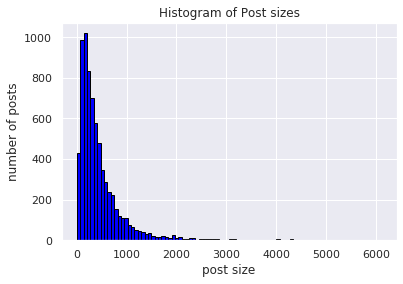

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(post_size, color = 'blue', edgecolor = 'black',
        bins = int(90))

# seaborn histogram
#sns.distplot(post_size, hist=True, kde=False, 
#             bins=int(90), color = 'blue',
#             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Post sizes')
plt.xlabel('post size')
plt.ylabel('number of posts')
plt.show()

In [23]:
users_posts = {}
total_posts = 0
maxposts = 0

for i, post in posts_traintest_df.iterrows():
    author = post["author"]
    if author not in users_posts:
        users_posts[author] = 0
    users_posts[author] += 1
    if users_posts[author] > maxposts:
        maxposts = users_posts[author]
    total_posts += 1

print (total_posts / len(users_posts.keys()), maxposts)

1.2173180592991915 37


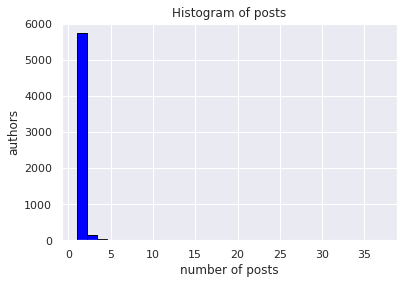

In [24]:
list_users_posts = []

for user in users_posts:
    list_users_posts.append(users_posts[user])

# matplotlib histogram
plt.hist(list_users_posts, color = 'blue', edgecolor = 'black',
        bins = int(30))

# seaborn histogram
#sns.distplot(post_size, hist=True, kde=False, 
#             bins=int(90), color = 'blue',
#             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of posts')
plt.xlabel('number of posts')
plt.ylabel('authors')
plt.show()

In [25]:
np.sqrt(np.std(list_users_posts))

0.8861080927342878

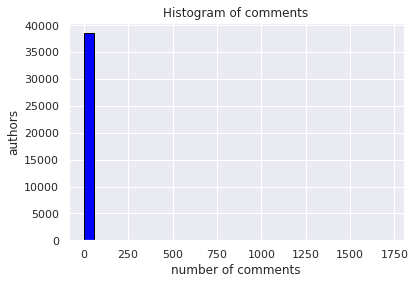

In [26]:
list_users_comments = []

for user in users_comments:
    list_users_comments.append(users_comments[user])

# matplotlib histogram
plt.hist(list_users_comments, color = 'blue', edgecolor = 'black',
        bins = int(30))

# seaborn histogram
#sns.distplot(post_size, hist=True, kde=False, 
#             bins=int(90), color = 'blue',
#             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of comments')
plt.xlabel('number of comments')
plt.ylabel('authors')
plt.show()

In [27]:
np.sqrt(np.std(list_users_comments))

3.316258296158984

In [28]:
np.max(list_users_comments)

1715

In [29]:
# import urllib3
# import json
# from bs4 import BeautifulSoup
# import requests
import pandas as pd

dataset=pd.DataFrame()

## Comment tree download from PRAW 

In [30]:
import praw
reddit = praw.Reddit(client_id='KjQ7KCga-fZb1w',
                     client_secret="JmEK20QNxS_WK0EeXKldbFSch04", password='XKfiQ.G5HsW#9a$',
                     user_agent='ChangeMeClient/0.1 by pantut', username='pantut')

In [31]:
fully_labeled = 0
partially_labeled = 0
fully_unlabeled = 0

comm_lengths = []

In [32]:
from tqdm import tqdm

In [33]:
# comment level data
commentid = []
treeid = []
authors = []
created_utc = []
score = []
wordcount = []
full_text = []
parent = []
postid = []
values = [[], [], [], [], [], []]

# tree level data
treeid_t = []
depth_t = []
length_t = []

In [34]:
comment_idx = 0
tree_idx = 1000000

def _get_comment_idx():
    global comment_idx
    comment_idx += 1
    return comment_idx

def _get_tree_idx():
    global tree_idx
    tree_idx += 1
    return tree_idx

In [ ]:
keys = [key for key in post_comments.keys()]
for ind, submission_id in tqdm(enumerate(keys)):
    if 'E+' in submission_id:
        continue
    
    labeled_timestamps = post_comments[submission_id]['timestamp']
    num_labeled_comments = len(labeled_timestamps)
    
    '''
    timestamps2labels['emo_support'] = {.. whether comments wrt timestamps are weakly labeled ..}
    '''
    timestamps2label = [{}]*6
    for i in range(6):
        for ts in labeled_timestamps:
            timestamps2label[i][ts] = -1
        for j, value in enumerate(post_comments[submission_id][labels[i]]):
            ts = labeled_timestamps[j]
            if value == -1:
                continue
            elif value == 0 and timestamps2label[i][ts] == -1:
                timestamps2label[i][ts] = 0
            elif value == 0 and timestamps2label[i][ts] == 1:
                continue
            else:
                timestamps2label[i][ts] = 1
    
#     print (timestamps2label)
    
    submission = reddit.submission(id=submission_id)
    submission.comments.replace_more(limit=0)
    
    def parse_comment(comment, tree_id, parent_id, depth = 1, length = 1):
        newcomment_idx = _get_comment_idx()
        
        ts = comment.created_utc
        
        '''
        prepare data for collection
        '''
        commentid.append(newcomment_idx)
        treeid.append(tree_id)
        authors.append(comment.author)
        created_utc.append(comment.created_utc)
        score.append(comment.score)
        wordcount.append(len(comment.body.split()))
        full_text.append(comment.body)
        parent.append(parent_id)
        postid.append(submission_id)
        for i, label in enumerate(labels):
            if ts in timestamps2label[i]:
                values[i].append(timestamps2label[i][ts])
            else:
                values[i].append(-1)
        
        max_depth = depth
        
        for reply in comment.replies:
            d, l = parse_comment(reply, tree_id, newcomment_idx, depth + 1)
            max_depth = max(max_depth, d)
            length += l
        
        return max_depth, length
    
    for comment in submission.comments:
        if comment.score <= -100:
            # don't process highly negative voted comments
            continue
        
        treeidx = _get_tree_idx()
        
        depth, length = parse_comment(comment, treeidx, -1)
        
        treeid_t.append(treeidx)
        depth_t.append(depth)
        length_t.append(length)

## Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
forest_df = pd.read_csv('forest.csv')
tree_info = pd.read_csv('tree_info.csv')

In [3]:
forest_df.columns

Index(['Unnamed: 0', 'commentid', 'treeid', 'authors', 'created_utc', 'score',
       'wordcount', 'full_text', 'parent', 'postid', 'Emotional_disclosure',
       'Emotional_disclosure_sentid', 'Information_disclosure',
       'Information_disclosure_sentid', 'Support', 'Support_sentid',
       'General_support', 'General_support_sentid', 'Info_support',
       'Info_support_sentid', 'Emo_support', 'Emo_support_sentid'],
      dtype='object')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(); np.random.seed(0)

List of posts that are partially marked labeled

In [5]:
# number of posts
N = len(set(forest_df['postid']))
print ("Number of all posts", N)

Number of all posts 8367


In [8]:
p_id = []
p_labeled = np.zeros(N)
p_length = np.zeros(N)

p_id.append(forest_df['postid'][0])
for index, row in forest_df.iterrows():
    if (row['postid'] != p_id[-1]):
        p_id.append(row['postid'])
    index = len(p_id) - 1
    if (row[labels[0]] != -1): # then partially labeled post
        p_labeled[index] = 1
    if (row['wordcount'] != 1): # then comment is not deleted
        p_length[index] += 1

Number of partially labeled posts 3582
Mean length of partially labeled posts 23.64
Stddev length of partially labeled posts 44.08


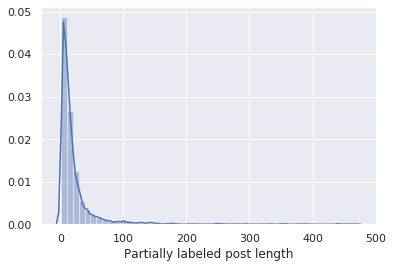

In [11]:
p_labeled_length = pd.Series(p_length[p_labeled == 1], name="Partially labeled post length")
print ("Number of partially labeled posts", len(p_labeled_length))
print ("Mean length of partially labeled posts {0:.2f}".format(np.mean(p_labeled_length)))
print ("Stddev length of partially labeled posts {0:.2f}".format(np.std(p_labeled_length)))
ax = sns.distplot(p_labeled_length)
plt.savefig("1.png")

Number of posts with at-least 5 length 2763
Mean length of partially labeled posts with at-least 5 length 29.67
Stddev length of partially labeled posts with at-least 5 length 48.58


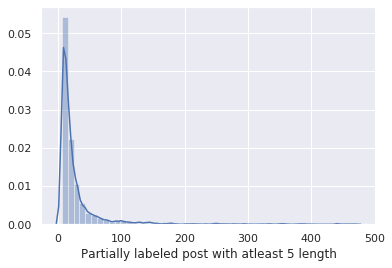

In [12]:
p_labeled_length = p_length[p_labeled == 1]
p_labeled_length = pd.Series(p_labeled_length[p_labeled_length > 5], name="Partially labeled post with atleast 5 length")
print ("Number of posts with at-least 5 length", len(p_labeled_length))
print ("Mean length of partially labeled posts with at-least 5 length {0:.2f}".format(np.mean(p_labeled_length)))
print ("Stddev length of partially labeled posts with at-least 5 length {0:.2f}".format(np.std(p_labeled_length)))
ax = sns.distplot(p_labeled_length)
plt.savefig("2.png")

Number of posts with at-least 10 length 1950
Mean length of partially labeled posts with at-least 10 length 38.77
Stddev length of partially labeled posts with at-least 10 length 55.33


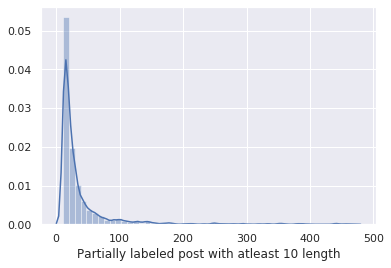

In [13]:
p_labeled_length = p_length[p_labeled == 1]
p_labeled_length = pd.Series(p_labeled_length[p_labeled_length > 10], name="Partially labeled post with atleast 10 length")
print ("Number of posts with at-least 10 length", len(p_labeled_length))
print ("Mean length of partially labeled posts with at-least 10 length {0:.2f}".format(np.mean(p_labeled_length)))
print ("Stddev length of partially labeled posts with at-least 10 length {0:.2f}".format(np.std(p_labeled_length)))
ax = sns.distplot(p_labeled_length)
plt.savefig("3.png")

Mean length of all posts 17.04
Stddev length of all posts 35.02


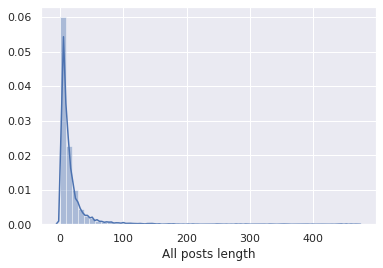

In [14]:
p_all_length = pd.Series(p_length, name="All posts length")
print ("Mean length of all posts {0:.2f}".format(np.mean(p_all_length)))
print ("Stddev length of all posts {0:.2f}".format(np.std(p_all_length)))
ax = sns.distplot(p_all_length)
plt.savefig("4.png")

Mean score of partially labeled post 163.42
Stddev score of partially labeled post 784.97


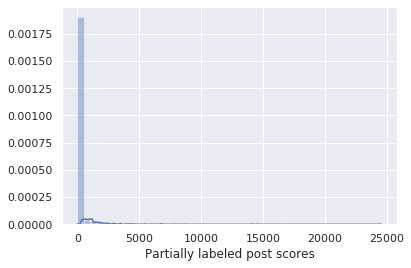

In [19]:
p_post_score = pd.Series(posts_traintest_df.score.values,index=posts_traintest_df.id_1).to_dict()

p_id = np.array(p_id)
p_labeled_post_scores = pd.Series([p_post_score[id] for id in p_id[p_labeled == 1] if id in p_post_score], 
                                  name="Partially labeled post scores")

print ("Mean score of partially labeled post {0:.2f}".format(np.mean(p_labeled_post_scores)))
print ("Stddev score of partially labeled post {0:.2f}".format(np.std(p_labeled_post_scores)))
ax = sns.distplot(p_labeled_post_scores)
plt.savefig("5.png")

Mean score of all posts 110.67
Stddev score of all posts 632.60


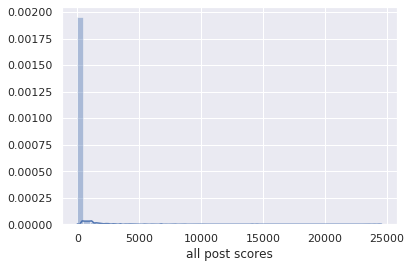

In [20]:
p_post_score = pd.Series(posts_traintest_df.score.values,index=posts_traintest_df.id_1).to_dict()

p_id = np.array(p_id)
p_all_post_scores = pd.Series([p_post_score[id] for id in p_id if id in p_post_score], 
                                  name="all post scores")

print ("Mean score of all posts {0:.2f}".format(np.mean(p_all_post_scores)))
print ("Stddev score of all posts {0:.2f}".format(np.std(p_all_post_scores)))
ax = sns.distplot(p_all_post_scores)
plt.savefig("6.png")